# Topology
This example reproduces the topology constraint.

In [1]:
from quadcoil import quadcoil
from quadcoil.quantity import K_theta, Phi_with_net_current, K2, K, f_B, f_K

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready
import time

In [3]:
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.geo import SurfaceRZFourier 
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

## Loading data

In [4]:
# The example is li383.
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
import jax
jax.config.update('jax_enable_x64', True)

## Running NESCOIL for comparison

In [5]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running nescoil, with auto-generated '\
      'winding surface.')
nescoil_out_dict, nescoil_qp, nescoil_phi_mn, _ = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    objective_weight=None,
    objective_unit=None,
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running nescoil, with auto-generated winding surface.


## Running QUADCOIL, constraining the coils to be purely poloidal


In [7]:
if net_poloidal_current_amperes > 0:
    K_theta_sign = '>='
else:
    K_theta_sign = '<='
print('K_theta constraint sign: ' + K_theta_sign)

K_theta constraint sign: >=


In [8]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running quadcoil, with auto-generated '\
      'winding surface and K_theta constraint.')
out_dict, qp, phi_mn, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    # Set the constraint to K_theta
    constraint_name=('K_theta',),
    constraint_type=('>=',),
    constraint_value=np.array([0.,]),
    constraint_unit=(None,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K'),
)

Running quadcoil, with auto-generated winding surface and K_theta constraint.


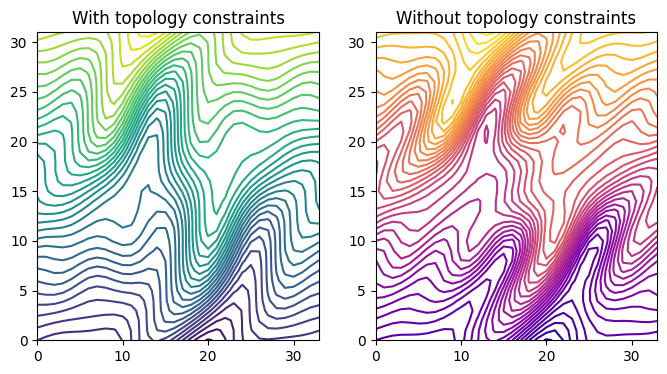

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('With topology constraints')
plt.contour(Phi_with_net_current(qp, phi_mn), levels=40)
plt.subplot(1,2,2)
plt.title('Without topology constraints')
plt.contour(Phi_with_net_current(qp, nescoil_phi_mn), levels=40, cmap='plasma')

In [10]:
print('f_B with K_theta constraints:', out_dict['f_B']['value'])
print('f_B with no constraints     :', nescoil_out_dict['f_B']['value'])
print('K_theta without constraints :', jnp.min(K_theta(qp, nescoil_phi_mn)))
print('K_theta with constraints    :', jnp.min(K_theta(qp, phi_mn)))

f_B with K_theta constraints: 0.07299502865308444
f_B with no constraints     : 0.042907422677962596
K_theta without constraints : -23835555.980880983
K_theta with constraints    : -0.3668615948408842


## Output structure
The following blocks look at the structure of outputs from QUADCOIL.

In [11]:
# Printing the structure of a nested dictionary by recursion
def print_tree_structure(d, indent=0, tab = '    '):
    for key, value in d.items():
        if isinstance(value, dict):
            print(tab * indent + '\'' + str(key) + '\'' + ': {')
            print_tree_structure(value, indent + 1)
            print(tab * indent + '},')
        else:
            if jnp.isscalar(value):
                print(tab * indent + '\'' + str(key) + '\'' + ': ' + str(value) + ',')
            else:
                print(tab * indent + '\'' + str(key) + '\': array(dtype=' + str(value.dtype) + ', shape=' + str(value.shape) + '),')

In [12]:
print_tree_structure(out_dict)

'f_B': {
    'dfdy1': array(dtype=float64, shape=(191,)),
    'dfdy2': array(dtype=float64, shape=(191,)),
    'grad': {
        'df_dconstraint_value': array(dtype=float64, shape=(1,)),
        'df_dnet_poloidal_current_amperes': 1.2366256568611395e-08,
        'df_dnet_toroidal_current_amperes': 7.735921323857575e-09,
        'df_dplasma_coil_distance': 0.9184905694886005,
        'df_dplasma_dofs': array(dtype=float64, shape=(187,)),
    },
    'value': 0.07299502865308444,
},
'f_K': {
    'dfdy1': array(dtype=float64, shape=(191,)),
    'dfdy2': array(dtype=float64, shape=(191,)),
    'grad': {
        'df_dconstraint_value': array(dtype=float64, shape=(1,)),
        'df_dnet_poloidal_current_amperes': 12304117.961687136,
        'df_dnet_toroidal_current_amperes': 1152546.5847180227,
        'df_dplasma_coil_distance': 268527688939079.62,
        'df_dplasma_dofs': array(dtype=float64, shape=(187,)),
    },
    'value': 73343701156926.25,
},


# Taylor test

In [14]:
outdict_list = []
plasma_dof_0_list = []
time_quadcoil_list = []
time_regcoil_list = []
lam_list = []
mu_list = []
c_list = []
qp_list = []
dof_test_list = []
test_i = 1
for i in jnp.linspace(-0.1, 0.1, 40):
    plasma_dof_i = plasma_surface.get_dofs().copy()
    plasma_dof_i[test_i] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    out_dict_i, qp_i, dofs_i, status_i = quadcoil(
        nfp=plasma_surface.nfp,
        stellsym=plasma_surface.stellsym,
        mpol=6,
        ntor=6,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=plasma_surface.mpol,
        plasma_ntor=plasma_surface.ntor,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=0.,
        plasma_coil_distance=plasma_surface.minor_radius(),
        # Set the objective to 
        # f_B
        objective_name='f_B',
        # Set the constraint to K_theta
        constraint_name=('K_theta',),
        constraint_type=('>=',),
        constraint_value=np.array([0.,]),
        constraint_unit=(None,),
        # Set the output metrics to f_B and f_K
        metric_name=('f_B', 'f_K'),
    )
    qp_list.append(qp_i)
    print('f_B!!!!!!!', f_B(qp_i, dofs_i))
    block_until_ready(dofs_i)
    block_until_ready(out_dict_i)
    block_until_ready(qp_i)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    print('time:', time2-time1)
    # REGCOIL ---------------------------------------------------
    plasma_dof_0_list.append(plasma_dof_i[test_i])
    outdict_list.append(out_dict_i)
    dof_test_list.append(dofs_i)
    lam_list.append(status_i['inner_fin_lam'])
    mu_list.append(status_i['inner_fin_mu'])
    c_list.append(status_i['inner_fin_c'])
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')

f_B!!!!!!! 0.037404677763084745
time: 44.01871466636658
f_B!!!!!!! 0.037407520774791085
time: 2.934427261352539
f_B!!!!!!! 0.03741035139654954
time: 2.909339666366577
f_B!!!!!!! 0.037413209164393744
time: 2.7027158737182617
f_B!!!!!!! 0.03741607555392289
time: 2.651801109313965
f_B!!!!!!! 0.03741900856262985
time: 2.4624080657958984
f_B!!!!!!! 0.03742177887543602
time: 2.5315699577331543
f_B!!!!!!! 0.03742460165483544
time: 2.581118106842041
f_B!!!!!!! 0.03742746106900935
time: 2.6166858673095703
f_B!!!!!!! 0.03743027814014334
time: 2.5105528831481934
f_B!!!!!!! 0.03743313055255513
time: 2.509133815765381
f_B!!!!!!! 0.03743592591421248
time: 3.6842234134674072
f_B!!!!!!! 0.03743891598538723
time: 2.5726449489593506
f_B!!!!!!! 0.03744162123724869
time: 2.7160823345184326
f_B!!!!!!! 0.03744445678735197
time: 2.8619210720062256
f_B!!!!!!! 0.03744734692691226
time: 2.7760705947875977
f_B!!!!!!! 0.03745017182365379
time: 3.628119945526123
f_B!!!!!!! 0.03745303391360855
time: 2.4576373100280

In [15]:
stacked_outdict = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs, axis=0), *outdict_list)
stacked_dofs = jax.tree_util.tree_map(lambda *xs: jnp.stack(xs, axis=0), *dof_test_list)

Text(0.5, 0, '$dof_{1}$ of plasma surface')

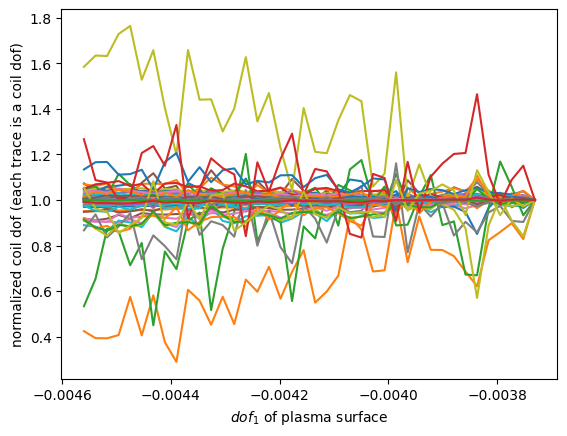

In [16]:
# Axis 1 is case id
# axis 2 is dof label
for i_plot in range(stacked_dofs['phi'].shape[1]):
    plt.plot(plasma_dof_0_list, stacked_dofs['phi'][:, i_plot]/stacked_dofs['phi'][0, i_plot])
plt.ylabel('normalized coil dof (each trace is a coil dof)')
plt.xlabel('$dof_{'+str(test_i)+'}$ of plasma surface')

Text(0.5, 0, '$dof_{1}$ of plasma surface')

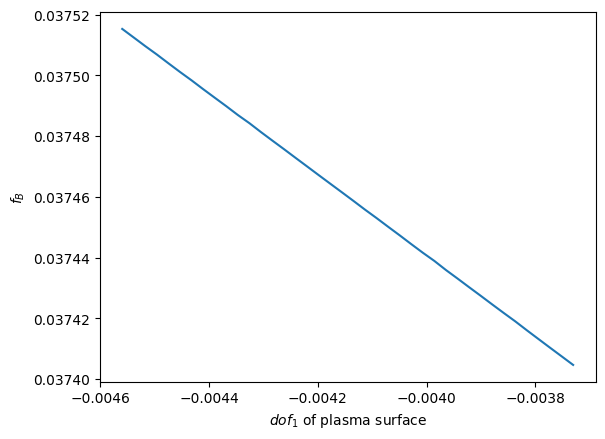

In [17]:
plt.plot(plasma_dof_0_list, stacked_outdict['f_B']['value'])
plt.ylabel('$f_B$')
plt.xlabel('$dof_{'+str(test_i)+'}$ of plasma surface')

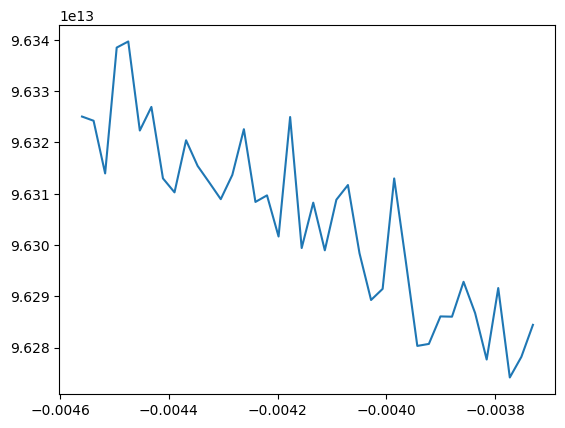

In [18]:
plt.plot(plasma_dof_0_list, stacked_outdict['f_K']['value'])

In [19]:
# The gradient is inaccurate.
# The inverses are accurate
# 
# Not sure if we're at a stationary point
plt.plot(stacked_outdict['f_B']['hess_err_norm'])
plt.plot(stacked_outdict['f_K']['hess_err_norm'])

KeyError: 'hess_err_norm'

In [ ]:
plt.plot(c_list)

In [ ]:
plt.plot(jnp.linalg.norm(jnp.array(mu_list), axis=1))

In [ ]:
# Even using lstsq the actual derivative values don't change much
grad_f_max_Phi = jnp.gradient(stacked_outdict['f_B']['value'], plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_max_Phi, label='REGCOIL & numpy.gradient')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_B']['grad']['df_dplasma_dofs'][:, test_i], label='QUADCOIL')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_B']['grada']['df_dplasma_dofs'][:, test_i], label='QUADCOIL1')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_B']['gradb']['df_dplasma_dofs'][:, test_i], label='QUADCOIL2', marker='x')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_B']['gradc']['df_dplasma_dofs'][:, test_i], label='QUADCOIL3', marker='x')
# plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list2, label='QUADCOIL2', linestyle='dashed')
plt.xlabel('$dof_{'+str(test_i)+'}$ of plasma surface')
plt.ylabel(r'$\partial f_B/\partial dof_{'+str(test_i)+'}$ (K$^2$m$^2$)')
# plt.ylim(jnp.min(grad_f_max_Phi), jnp.max(grad_f_max_Phi))
plt.legend()

In [ ]:
# Even using lstsq the actual derivative values don't change much
grad_f_max_Phi = jnp.gradient(stacked_outdict['f_K']['value'], plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_max_Phi, label='REGCOIL & numpy.gradient')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_K']['grad']['df_dplasma_dofs'][:, test_i], label='QUADCOIL')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_K']['grada']['df_dplasma_dofs'][:, test_i], label='QUADCOIL1')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_K']['gradb']['df_dplasma_dofs'][:, test_i], label='QUADCOIL2', marker='x')
plt.scatter(plasma_dof_0_list, stacked_outdict['f_K']['gradc']['df_dplasma_dofs'][:, test_i], label='QUADCOIL3', marker='x')
# plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list2, label='QUADCOIL2', linestyle='dashed')
plt.xlabel('$dof_{'+str(test_i)+'}$ of plasma surface')
plt.ylabel(r'$\partial f_K/\partial dof_{'+str(test_i)+'}$ (K$^2$m$^2$)')
# plt.ylim(jnp.min(grad_f_max_Phi), jnp.max(grad_f_max_Phi))
plt.legend()